In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


warnings.filterwarnings("ignore")

In [4]:
# Training Data Filepath
training_data_path = Path('/Users/yashwanth/Downloads/Data/Lung Disease Dataset/train')
train_filepath_list = list(training_data_path.glob(r'**/*.jp*'))
train_class_list = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepath_list))

# Validation Data Filepath

valdiation_data_path = Path('/Users/yashwanth/Downloads/Data/Lung Disease Dataset/val')
valdiation_filepath_list = list(valdiation_data_path.glob(r'**/*.jp*'))
valdiation_class_list = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], valdiation_filepath_list))


# Test Data Filepath

test_data_path = Path('/Users/yashwanth/Downloads/Data/Lung Disease Dataset/test')
test_filepath_list = list(test_data_path.glob(r'**/*.jp*'))
test_class_list = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepath_list))


In [6]:
final_df = pd.DataFrame(columns = ['filepath', 'class', 'type'])

train_df = [{'filepath': str(filepath), 'class': class_, 'type': 'train'} for filepath, class_, in zip(train_filepath_list, train_class_list)]
test_df = [{'filepath': str(filepath), 'class': class_, 'type': 'test'} for filepath, class_, in zip(test_filepath_list, test_class_list)]
valid_df = [{'filepath': str(filepath), 'class': class_, 'type': 'valid'} for filepath, class_, in zip(valdiation_filepath_list, valdiation_class_list)]

final_df = pd.concat([final_df, pd.DataFrame(train_df),pd.DataFrame(valid_df), pd.DataFrame(test_df) ])


In [7]:
final_df.head()

,filepath,class,type
0,/Users/chaitanyapavan/Downloads/Data/Lung Dise...,Tuberculosis,train
1,/Users/chaitanyapavan/Downloads/Data/Lung Dise...,Tuberculosis,train
2,/Users/chaitanyapavan/Downloads/Data/Lung Dise...,Tuberculosis,train
3,/Users/chaitanyapavan/Downloads/Data/Lung Dise...,Tuberculosis,train
4,/Users/chaitanyapavan/Downloads/Data/Lung Dise...,Tuberculosis,train


<Axes: xlabel='class', ylabel='count'>

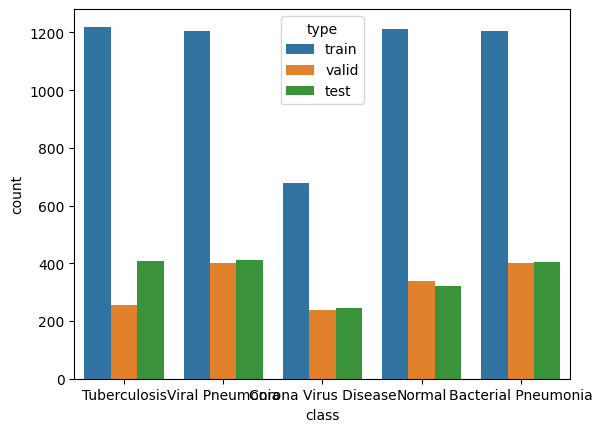

In [8]:
# Creating a countplot using seaborn to visualize the counts of classes with hue based on type
sns.countplot(data=final_df, x='class', hue='type')

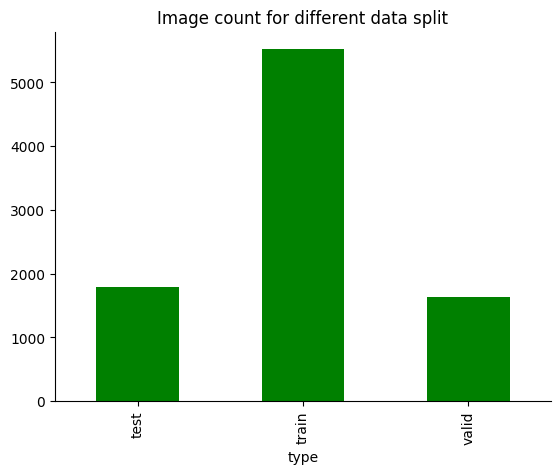

In [9]:
# Grouping final_df by 'type' and calculating the size of each group, then plotting as a bar plot with green color
final_df.groupby('type').size().plot(kind='bar', color='green')

# Adding title to the plot
plt.title('Image count for different data split')

# Removing top and right spines from the plot
plt.gca().spines[['top', 'right']].set_visible(False)


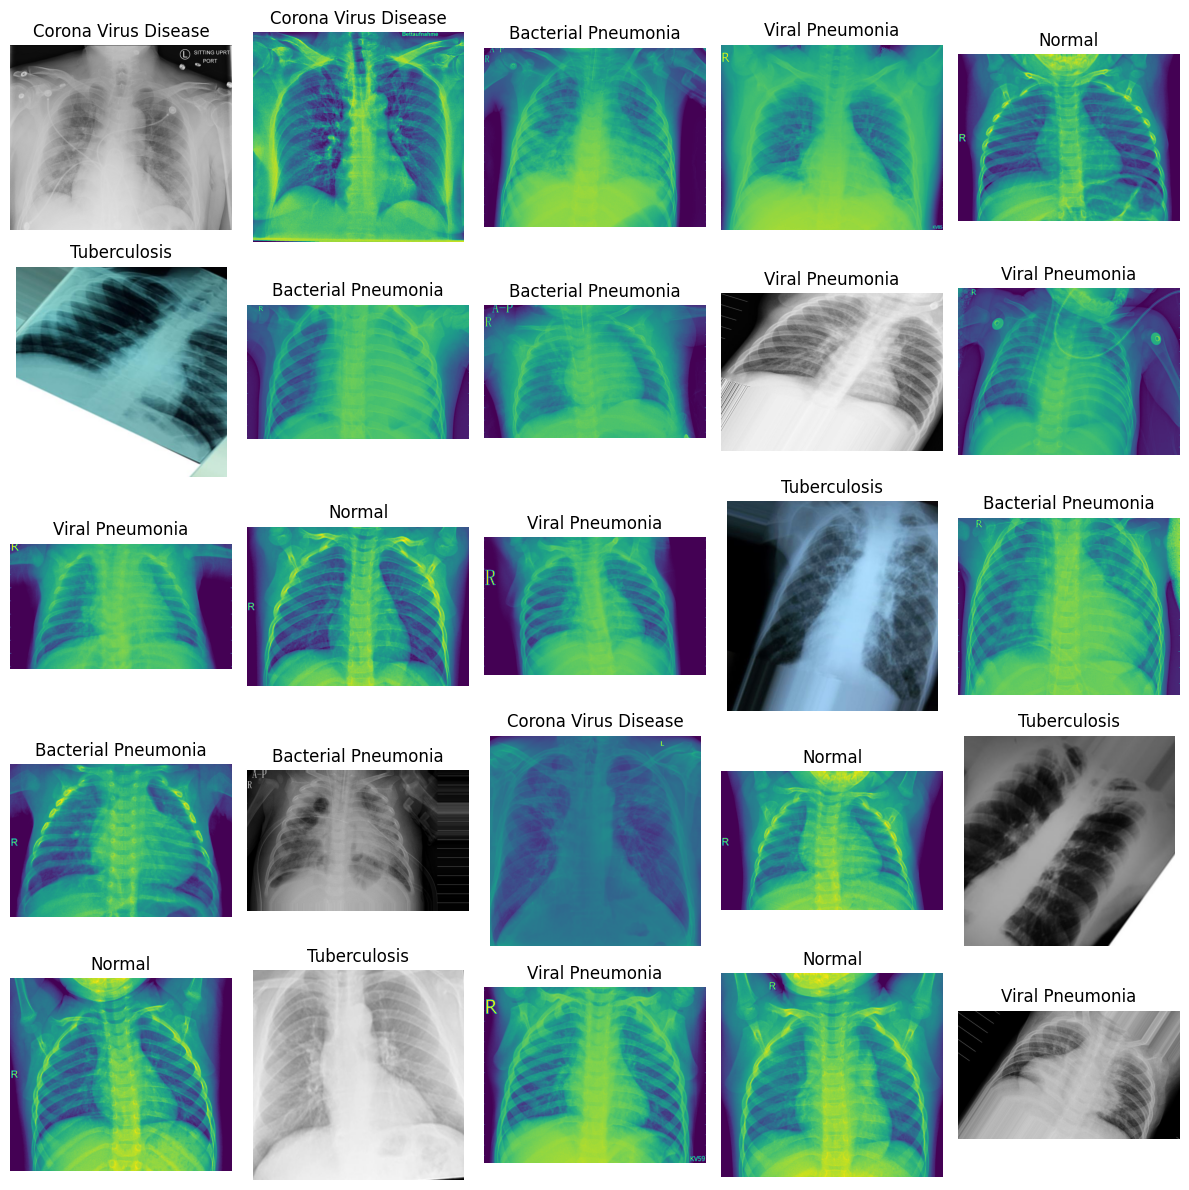

In [10]:
# Sampling 5*5 (25) random rows from final_df with random_state set to 42
sample_df = final_df.sample(5 * 5, random_state=42)

# Creating a figure with 5 rows and 5 columns, with a specified size
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

# Iterating over each axis and corresponding image path, title from sample_df
for ax, img_path, title in zip(axes.flat, sample_df['filepath'], sample_df['class']):
    # Loading and displaying the image on the current axis
    img = plt.imread(img_path)
    ax.imshow(img)
    # Setting title for the current axis
    ax.set_title(title)
    # Turning off axis labels for better visualization
    ax.axis('off')

# Adjusting the layout of the subplots to prevent overlapping
fig.tight_layout()
# Displaying the plot
plt.show()


In [11]:
# Setting up an instance of ImageDataGenerator for generating training data
# Rescales pixel values of images to be between 0 and 1
# Applies horizontal and vertical shifts up to 20% of the image's width and height
# Applies zooming up to 20%
train_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Setting up an instance of ImageDataGenerator for generating validation data
# Rescales pixel values of images to be between 0 and 1
val_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Setting up an instance of ImageDataGenerator for generating test data
# Rescales pixel values of images to be between 0 and 1
test_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [12]:
# Extracting training data from final_df
train_df = final_df[final_df['type'] == 'train'].drop('type', axis=1)

# Generating a flow of images and labels for training using the train_gen_instance
train_images = train_gen_instance.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical'
)

# Extracting validation data from final_df
valid_df = final_df[final_df['type'] == 'valid'].drop('type', axis=1)

# Generating a flow of images and labels for validation using the val_gen_instance
valid_images = val_gen_instance.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical'
)

# Extracting test data from final_df
test_df = final_df[final_df['type'] == 'test'].drop('type', axis=1)

# Generating a flow of images and labels for testing using the test_gen_instance
test_images = test_gen_instance.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    color_mode="grayscale",
    class_mode='categorical'
)


Found 5521 validated image filenames belonging to 5 classes.
Found 1633 validated image filenames belonging to 5 classes.
Found 1790 validated image filenames belonging to 5 classes.


In [13]:
# Loading VGG19 model with pre-trained weights from ImageNet dataset
vgg_19_base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freezing the layers of the base VGG19 model
for current_layer in vgg_19_base_model.layers:
    current_layer.trainable = False

# Creating a sequential model
vgg_19_model = tf.keras.models.Sequential()

# Adding a convolutional layer to convert grayscale images to RGB
vgg_19_model.add(tf.keras.layers.Conv2D(3, (3, 3), input_shape=(224, 224, 1), activation='relu', padding='same'))

# Adding the pre-trained VGG19 base model
vgg_19_model.add(vgg_19_base_model)

# Flattening the output from the VGG19 base model
vgg_19_model.add(tf.keras.layers.Flatten())

# Adding a dense layer with 256 units and ReLU activation
vgg_19_model.add(tf.keras.layers.Dense(256, activation='relu'))

# Adding a dropout layer with a dropout rate of 0.5
vgg_19_model.add(tf.keras.layers.Dropout(0.5))

# Adding the output layer with softmax activation for classification
vgg_19_model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compiling the model with Adam optimizer and categorical crossentropy loss
vgg_19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


2024-03-31 21:02:38.159911: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-31 21:02:38.159950: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-31 21:02:38.159965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-31 21:02:38.160015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 21:02:38.160037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# Training the VGG19 model using fit method
vgg_19_history = vgg_19_model.fit(
    train_images,
    epochs=20,
    validation_data=valid_images
)

# Saving the trained VGG19 model
vgg_19_model.save("vgg_19_trained_model.h5")


Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 8.0822 - acc: 0.3728

2024-03-31 21:08:11.190207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 146s 840ms/step - loss: 8.0822 - acc: 0.3728 - val_loss: 5.7208 - val_acc: 0.2823
Epoch 2/20
173/173 [==============================] - 144s 828ms/step - loss: 2.2205 - acc: 0.5506 - val_loss: 5.7109 - val_acc: 0.2609
Epoch 3/20
173/173 [==============================] - 141s 817ms/step - loss: 1.6682 - acc: 0.5979 - val_loss: 2.6297 - val_acc: 0.4274
Epoch 4/20
173/173 [==============================] - 144s 831ms/step - loss: 1.6392 - acc: 0.5983 - val_loss: 4.4363 - val_acc: 0.3497
Epoch 5/20
173/173 [==============================] - 143s 824ms/step - loss: 2.2605 - acc: 0.5827 - val_loss: 2.9340 - val_acc: 0.5144
Epoch 6/20
173/173 [==============================] - 145s 837ms/step - loss: 1.8223 - acc: 0.6160 - val_loss: 2.9739 - val_acc: 0.4874
Epoch 7/20
173/173 [==============================] - 142s 820ms/step - loss: 1.6119 - acc: 0.6412 - val_loss: 2.9945 - val_acc: 0.6001
Epoch 8/20
173/173 [==============================] - 140s 

In [ ]:
o

52/52 [==============================] - 15s 297ms/step


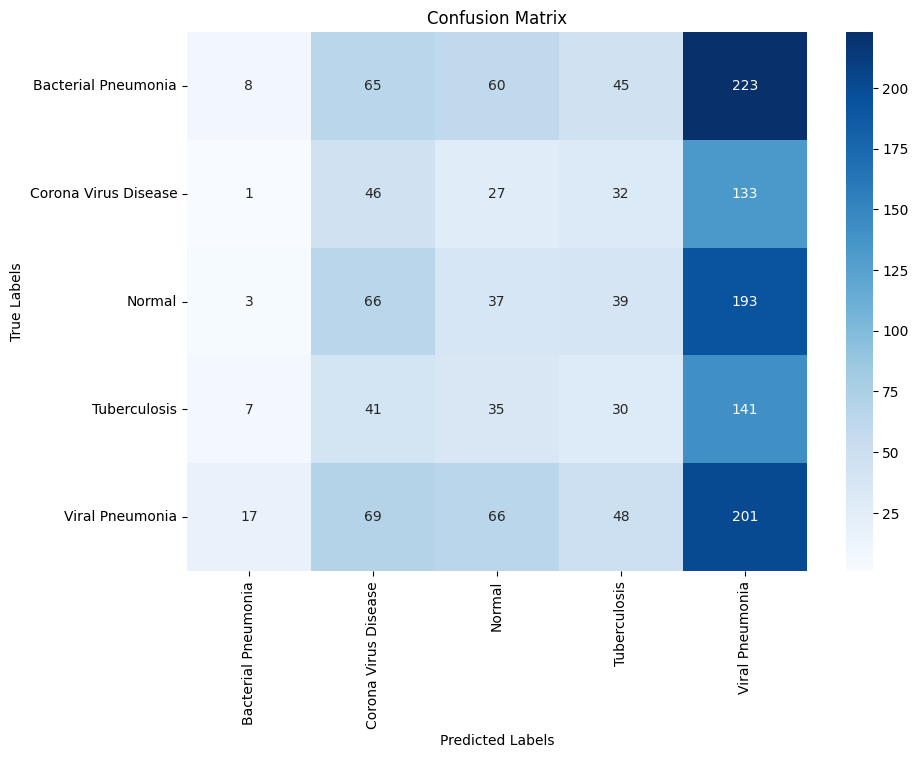

In [23]:
# Getting predicted classes from the trained VGG19 model
predicted_classes = np.argmax(vgg_19_model.predict(valid_images, steps=len(valid_images)), axis=1)

# Getting true classes from the validation generator
true_classes = valid_images.classes

# Getting class labels from the generator
class_labels = list(valid_images.class_indices.keys())

# Generating confusion matrix
cm_vgg = confusion_matrix(true_classes, predicted_classes)

# Plotting confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [20]:
vgg_19_model.save('vgg_19.h5')

In [24]:
# Loading MobileNet model with pre-trained weights from ImageNet dataset
mobilenet_base_model = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freezing the layers of the base MobileNet model
for current_layer in mobilenet_base_model.layers:
    current_layer.trainable = False

# Creating a sequential model
mobilenet_model = tf.keras.models.Sequential()

# Adding a convolutional layer to convert grayscale images to RGB
mobilenet_model.add(tf.keras.layers.Conv2D(3, (3, 3), input_shape=(224, 224, 1), activation='relu', padding='same'))

# Adding the pre-trained MobileNet base model
mobilenet_model.add(mobilenet_base_model)

# Flattening the output from the MobileNet base model
mobilenet_model.add(tf.keras.layers.Flatten())

# Adding a dense layer with 256 units and ReLU activation
mobilenet_model.add(tf.keras.layers.Dense(256, activation='relu'))

# Adding a dropout layer with a dropout rate of 0.5
mobilenet_model.add(tf.keras.layers.Dropout(0.5))

# Adding the output layer with softmax activation for classification
mobilenet_model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compiling the model with Adam optimizer and categorical crossentropy loss
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Training the MobileNet model using fit method
mobilenet_history = mobilenet_model.fit(
    train_images,
    epochs=20,
    validation_data=valid_images
)

# Saving the trained MobileNet model
mobilenet_model.save("mobilenet_trained_model.h5")


17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/20


2024-03-31 22:23:30.167151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - ETA: 0s - loss: 30.3640 - acc: 0.6124

2024-03-31 22:24:19.546384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 62s 350ms/step - loss: 30.3640 - acc: 0.6124 - val_loss: 11.6466 - val_acc: 0.7232
Epoch 2/20
173/173 [==============================] - 61s 349ms/step - loss: 10.7269 - acc: 0.7203 - val_loss: 15.4409 - val_acc: 0.6705
Epoch 3/20
173/173 [==============================] - 61s 350ms/step - loss: 9.0330 - acc: 0.7401 - val_loss: 16.2490 - val_acc: 0.6424
Epoch 4/20
173/173 [==============================] - 61s 350ms/step - loss: 7.2836 - acc: 0.7638 - val_loss: 11.4691 - val_acc: 0.6999
Epoch 5/20
173/173 [==============================] - 61s 350ms/step - loss: 7.1118 - acc: 0.7560 - val_loss: 29.7131 - val_acc: 0.5432
Epoch 6/20
173/173 [==============================] - 61s 350ms/step - loss: 6.9792 - acc: 0.7698 - val_loss: 13.9095 - val_acc: 0.6626
Epoch 7/20
173/173 [==============================] - 61s 350ms/step - loss: 6.2339 - acc: 0.7692 - val_loss: 13.5624 - val_acc: 0.6534
Epoch 8/20
173/173 [==============================] - 61s

2024-03-31 22:48:30.322441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 12s 232ms/step


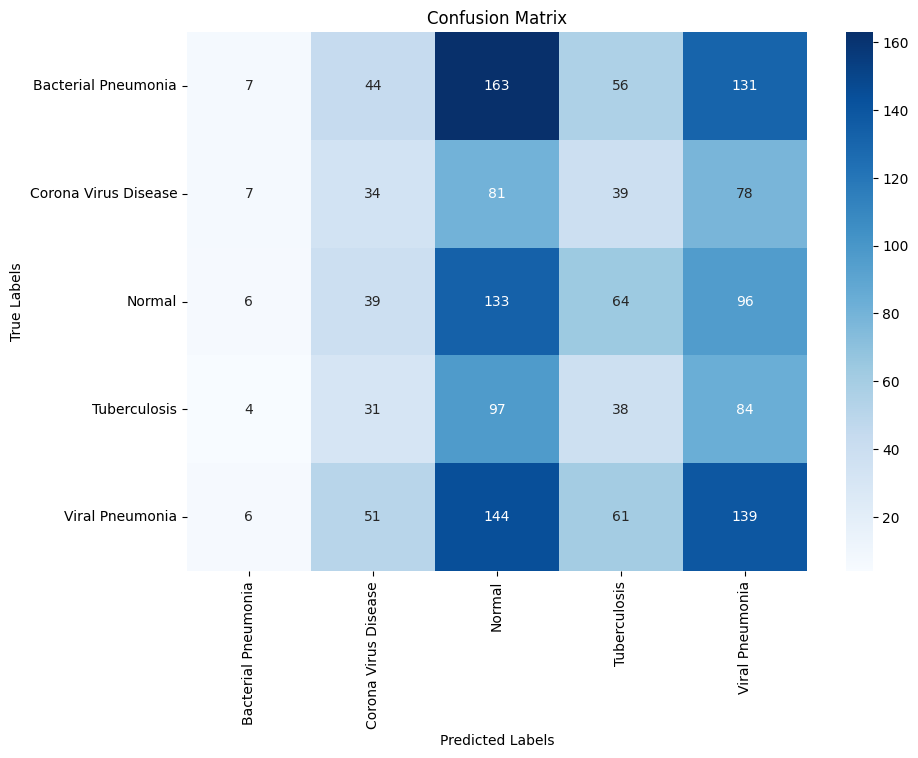

In [25]:
# Resetting the validation generator to its initial state
valid_images.reset()

# Getting predictions from the trained MobileNet model
predictions = mobilenet_model.predict(valid_images, steps=len(valid_images))

# Getting predicted classes from the predictions
predicted_classes = np.argmax(predictions, axis=1)

# Getting true classes from the validation generator
true_classes = valid_images.classes

# Generating confusion matrix
cm_mobile = confusion_matrix(true_classes, predicted_classes)

# Plotting confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mobile, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:
# Loading ResNet50 model with pre-trained weights from ImageNet dataset
resnet_base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freezing the layers of the base ResNet50 model
for current_layer in resnet_base_model.layers:
    current_layer.trainable = False

# Creating a sequential model
resnet_model = tf.keras.models.Sequential()

# Adding a convolutional layer to convert grayscale images to RGB
resnet_model.add(tf.keras.layers.Conv2D(3, (3, 3), input_shape=(224, 224, 1), activation='relu', padding='same'))

# Adding the pre-trained ResNet50 base model
resnet_model.add(resnet_base_model)

# Flattening the output from the ResNet50 base model
resnet_model.add(tf.keras.layers.Flatten())

# Adding a dense layer with 512 units and ReLU activation
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))

# Adding a dropout layer with a dropout rate of 0.5
resnet_model.add(tf.keras.layers.Dropout(0.5))

# Adding the output layer with softmax activation for classification
resnet_model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compiling the model with Adam optimizer and categorical crossentropy loss
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Training the ResNet50 model using fit method
resnet_history = resnet_model.fit(
    train_images,
    epochs=5,
    validation_data=valid_images
)


Epoch 1/5


2024-03-31 22:49:36.788861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - ETA: 0s - loss: 18.4518 - acc: 0.2174

2024-03-31 22:50:52.835144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


173/173 [==============================] - 91s 499ms/step - loss: 18.4518 - acc: 0.2174 - val_loss: 9.2838 - val_acc: 0.1555
Epoch 2/5
173/173 [==============================] - 82s 475ms/step - loss: 9.0274 - acc: 0.2356 - val_loss: 9.2910 - val_acc: 0.1555
Epoch 3/5
173/173 [==============================] - 82s 475ms/step - loss: 15.6000 - acc: 0.2755 - val_loss: 18.2437 - val_acc: 0.2266
Epoch 4/5
173/173 [==============================] - 82s 471ms/step - loss: 12.2191 - acc: 0.3436 - val_loss: 22.0881 - val_acc: 0.2400
Epoch 5/5
173/173 [==============================] - 82s 471ms/step - loss: 12.6156 - acc: 0.3670 - val_loss: 13.0093 - val_acc: 0.3319


52/52 [==============================] - 12s 236ms/step


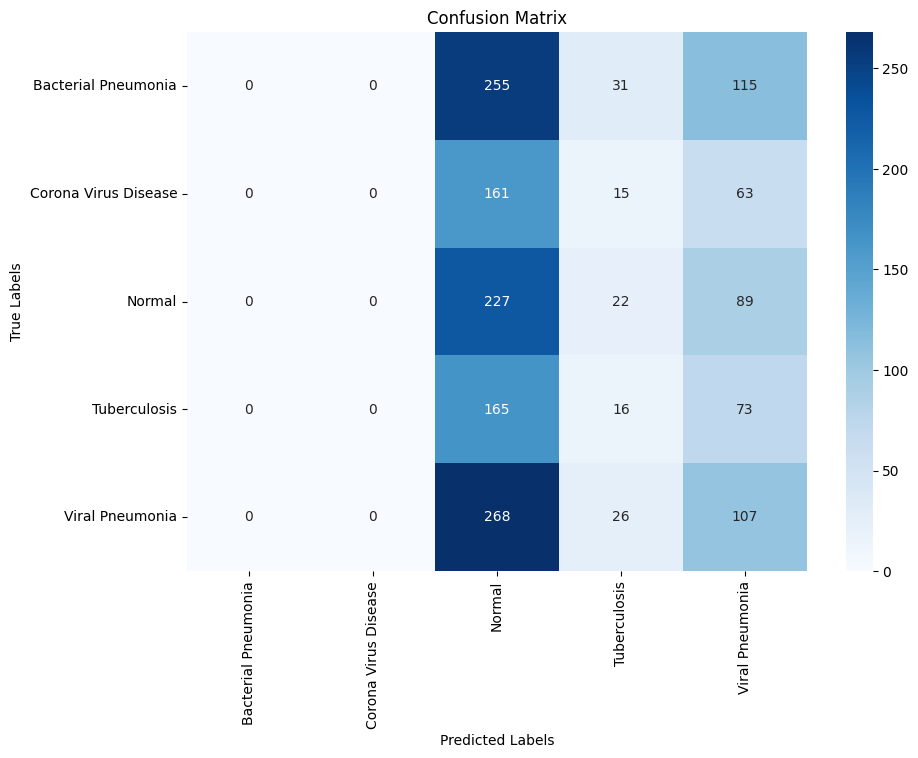

In [30]:
# Resetting the validation generator to its initial state
valid_images.reset()

# Getting predictions from the trained ResNet model
predictions_resnet = resnet_model.predict(valid_images, steps=len(valid_images))

# Getting predicted classes from the predictions
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)

# Getting true classes from the validation generator
true_classes_resnet = valid_images.classes

# Generating confusion matrix
cm_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)

# Plotting confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()